# Clustering on mixed data-types

This article focusses on theory, method and practical application of clustering of datasets with mixed datatypes. Many real world datasets include combinations of numerical, ordianl (e.g. small, medium, large), and ordinal (e.g. France, China, India) data features. Whereas many popular clustering algorithms such as Kmeans are suitable only for either numerical or categorical datatypes independantly. Sklearn provides and excellent [introduction to clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) methods. Lets begin.

Cluster analysis (clustering) is the task of assigning sets of objects within a population in such a way that objects in the same group (cluster) are more similar to one another than to those in other clusters. Clustering is a form of unsupervised learning as the number, size and distribution of clusters is unknown a priori.

Clustering can be applied to a variety of different problems and domains including: customer segmentation for retail sales and marketing, identifying higher or lower risk groups within [insurance portfolios](https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf), to finding [storm systems on Jupyter](https://astronomycommunity.nature.com/users/253561-ingo-waldmann/posts/48323-deep-learning-saturn), and even [galaxies far far away](https://arxiv.org/abs/1404.3097).



In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import tensorflow_data_validation as tfdv

### 1. Case Study: Auto insurance claims [dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data)

In [2]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../_data')
df = pd.read_csv(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim.csv'),low_memory=False,)

# convert object to numerical
df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]] = df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0)

# clean textual classes
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(df.columns,df.dtypes)}

df[:2]

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,MAR,60.0,0,11.0,67349.0,NO,0.0,NO,...,MINIVAN,YES,4461.0,2,NO,3,0.0,18.0,0,HIGHLYURBANURBAN
1,132761049,0,JAN,43.0,0,11.0,91449.0,NO,257252.0,NO,...,MINIVAN,YES,0.0,0,NO,0,0.0,1.0,0,HIGHLYURBANURBAN


***missing data***

In [3]:
df['OCCUPATION'].fillna('OTHER',inplace=True)
for col in ['AGE','YOJ','CAR_AGE']:
    df[col].fillna(df[col].mean(),inplace=True)
    
print(df.isnull().sum()[df.isnull().sum()>0])

Series([], dtype: int64)


### 2. Feature Encoding & Engineering

***what features do we have?***
Having explored I found this [data dictionary](https://rpubs.com/data_feelings/msda_data621_hw4) and following key definitions:
- Bluebook = car re-sale value. 
- MVR_PTS = [MotorVehicleRecordPoints (MVR) ](https://www.wnins.com/losscontrolbulletins/MVREvaluation.pdf) details an individual’s past driving history indicating violations and accidents over a specified period
- TIF = Time In Force / customer lifetime
- YOJ = years in job
- CLM_FRQ = # of claims in past 5 years
- OLDCLAIM = sum $ of claims in past 5 years

In [4]:
# copy df
tdf = df.copy()

In [5]:
feat_id = ['ID']
feat_account = ['KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
                'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION','URBANICITY','TIF',]
feat_car = [ 'TRAVTIME', 'CAR_USE','MVR_PTS','BLUEBOOK','CAR_TYPE', 'RED_CAR','REVOKED','CAR_AGE',]
feat_claims = ['OLDCLAIM', 'CLM_FREQ', 'CLAIM_FLAG','CLM_AMT',]

data_meta = pd.DataFrame(tdf.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta[:2]

,name,num
0,URBANICITY,2
1,REVOKED,2


***transform binary variables***

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
for feat in data_meta.loc[data_meta['num']<=12,'name'].values:
    tdf[feat] = le.fit_transform(tdf[feat])

### 2. EDA & Feat Eng
Lets go feature by feature and see if we can remove small feature spaces

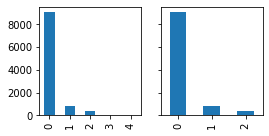

In [8]:
f = 'KIDSDRIV'
fig,ax = plt.subplots(1,2,figsize=(4,2),sharey=True)
tdf[f].value_counts().plot.bar(ax=ax[0]);
tdf.loc[tdf[f]>=2,f] = 2
tdf[f].value_counts().plot.bar(ax=ax[1])

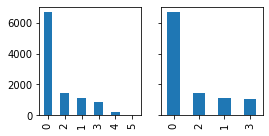

In [9]:
f = 'HOMEKIDS'
fig,ax = plt.subplots(1,2,figsize=(4,2),sharey=True)
tdf[f].value_counts().plot.bar(ax=ax[0]);
tdf.loc[tdf[f]>=3,f] = 3
tdf[f].value_counts().plot.bar(ax=ax[1])

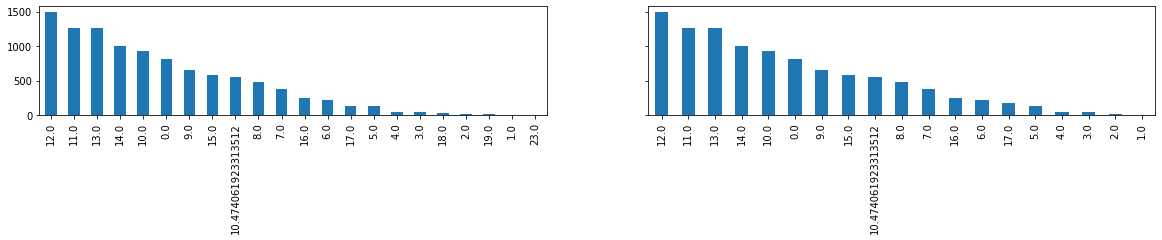

In [10]:
f = 'YOJ'
fig,ax = plt.subplots(1,2,figsize=(20,2),sharey=True)
tdf[f].value_counts().plot.bar(ax=ax[0]);
tdf.loc[tdf[f]>=17,f] = 17
tdf[f].value_counts().plot.bar(ax=ax[1])

# [Scaled & Dummary Vars](https://datascience.stackexchange.com/a/24/47485)

In [61]:
data_meta = pd.DataFrame(tdf.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']

dummys=dict()

for feat in data_meta.loc[data_meta['num']<=12,'name'].values:
    dummys[feat] = pd.get_dummies(tdf[feat])

In [62]:
from sklearn import preprocessing
def scaled(df,feat):
    x = df[[feat]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled

In [63]:
scaled = {x:scaled(tdf,x) for x in data_meta.loc[data_meta['num']>12,'name'].values if 'ID' not in x}

In [70]:
pd.DataFrame(scaled['MVR_PTS'])

,0
0,0.230769
1,0.000000
2,0.153846
3,0.230769
4,0.000000
...,...
10297,0.153846
10298,0.000000
10299,0.000000
10300,0.000000


In [50]:
pd.DataFrame.from_dict(dummysa)

TypeError: from_dict() got an unexpected keyword argument 'index'

In [ ]:
Xy = tdf[feat_account+feat_car+feat_claims].copy()
Xy.columns

### 4. Similarity

[$Gower$ $distance$](https://www.jstor.org/stable/2528823?seq=1) was proposed to measure dissimilarity between subjects with mixed types of variables using the mathematical concept of distance.
- [docs](https://rdrr.io/cran/gower/api)

In [ ]:
import gower

# # Example: to find the most similar record to i=0, in rows i=1...i=100
# gower.gower_topn(Xy.iloc[0:1,:], Xy.iloc[1:100,], n = 1)
# Xy.iloc[[0,42],:].T

In [ ]:
try: 
    gd = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'))
    print('Gower distances loaded from file.')
except:
    print('Calculating Gower dsitances...5-8 minutes')
    %time gd = gower.gower_matrix(Xy[:])
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'),gd)

### 5. Clustering

In [ ]:
# k-mediods python implmentation in scikit-learn-extra
# https://scikit-learn-extra.readthedocs.io/en/latest/install.html
# C++ build tools may be required on windows
# https://www.scivision.dev/python-windows-visual-c-14-required/

# or k-mediods in pyclustering
# https://pypi.org/project/pyclustering/

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.silhouette import silhouette

In [ ]:
k = 3
n = 10000
print(f'contains nans:\t{np.isnan(gd).any()}')
sample = np.nan_to_num(gd[:n,:n])
print(f'sample:\t{n}\nshape:\t{sample.shape}')

In [ ]:
# import networkx as nx

# G = nx.from_numpy_matrix(sample)
# edge_list = [i for i in nx.generate_edgelist(G,data=True)]

***Cluster $k=n$***

In [ ]:
# initiate k random medoids
# also sets k clusters
%time
k = 4
initial_medoids = np.random.randint(0,1000,size=k)
print(f'Initial medoids:\t{initial_medoids}')
      
kmedoids_instance = kmedoids(sample,initial_medoids, data_type='distance_matrix')

# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# score
# The silhouette value is a measure of how similar an object
# is to its own cluster compared to other clusters
score = silhouette(data=sample, clusters=clusters,data_type='distance_matrix').process().get_score()

In [ ]:
for k in clusters: print(f'k={len(k)}') 

***Cluster using silhouette score to find $max(k)$***
- [visualizer seems to work with paierd list only](https://github.com/annoviko/pyclustering/issues/499)

In [ ]:
# search using silhouette score
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1silhouette_1_1silhouette__ksearch.html
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
import pickle

try:
    search_instance = pickle.load(os.path.join(DATA_PATH,'car-insurance-claim-data/kmode-search-6-8.pickle'), "rb" )
except:
    search_instance = silhouette_ksearch(sample, kmin=3, kmax=6, algorithm=silhouette_ksearch_type.KMEDOIDS).process()
    pickle.dump(search_instance, open(os.path.join(DATA_PATH,'car-insurance-claim-data/kmode-search-6-8.pickle'), "wb" ))

amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

# Create instance of K-Medoids algorithm with optimal settings from search
initial_medoids = np.random.randint(0,n,size=amount)
kmedoids_instance = kmedoids(sample,initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# capture results
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

In [ ]:
len(clusters), sample.shape

# Visualise

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy[:n])

In [ ]:
tsne_df = pd.DataFrame(tsne)

tsne_df['cluster'] = np.nan
for e,k in enumerate(clusters):
    print(e,len(k))
    tsne_df.iloc[k,-1] = e

In [ ]:
groups = tsne_df.groupby('cluster')

fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', label=name)
ax.legend()
plt.show()

# [CLARANS](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)

In [ ]:
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
# from sklearn import datasets

# #import iris dataset from sklearn library
# iris =  datasets.load_iris();

# #get the iris data. It has 4 features, 3 classes and 150 data points.
# data = iris.data

# """!
# The pyclustering library clarans implementation requires
# list of lists as its input dataset.
# Thus we convert the data from numpy array to list.
# """
# data = data.tolist()

In [ ]:
data = Xy.to_numpy().tolist()

In [ ]:
#get a glimpse of dataset
print("A peek into the dataset : ",data[:4])


"""!
@brief Constructor of clustering algorithm CLARANS.
@details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
@param[in] data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
@param[in] number_clusters: amount of clusters that should be allocated.
@param[in] numlocal: the number of local minima obtained (amount of iterations for solving the problem).
@param[in] maxneighbor: the maximum number of neighbors examined.        
"""
clarans_instance = clarans(data, 3, 4, 4);

#calls the clarans method 'process' to implement the algortihm
(ticks, result) = timedcall(clarans_instance.process);
print("Execution time : ", ticks, "\n");

#returns the clusters 
clusters = clarans_instance.get_clusters();

#returns the mediods 
medoids = clarans_instance.get_medoids();


print("Index of the points that are in a cluster : ",clusters)
print("The target class of each datapoint : ",iris.target)
print("The index of medoids that algorithm found to be best : ",medoids)

# *References*

- https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
- https://medium.com/@rumman1988/clustering-categorical-and-numerical-datatype-using-gower-distance-ab89b3aa90d9
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://www.google.com/search?client=firefox-b-d&q=python+gower+distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://discuss.analyticsvidhya.com/t/clustering-technique-for-mixed-numeric-and-categorical-variables/6753
- https://stackoverflow.com/questions/24196897/r-distance-matrix-and-clustering-for-mixed-and-large-dataset
- https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://rpubs.com/data_feelings/msda_data621_hw4
- https://pypi.org/project/gower/
- https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
- https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05
- https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/pam
- https://github.com/annoviko/pyclustering/issues/499
- https://stats.stackexchange.com/questions/2717/clustering-with-a-distance-matrix
- https://www.kaggle.com/fabiendaniel/customer-segmentation
- https://dkopczyk.quantee.co.uk/claim-prediction/
- https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf
- https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4
- https://www.uio.no/studier/emner/matnat/math/nedlagte-emner/STK2510/v08/undervisningsmateriale/ch8b.pdf
- https://github.com/annoviko/pyclustering/issues/499
- https://stackoverflow.com/questions/3081066/what-techniques-exists-in-r-to-visualize-a-distance-matrix
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
- https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
- http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale